# Exercise 7:  Many Objects and Distributions
Kevin Mader  
April 14, 2016

In [1]:
# we don't need all of these packages for this exercise but many of them are anyways useful
from __future__ import absolute_import, division, print_function
import os
import json as pjson
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from skimage.measure import block_reduce
imreadli = lambda ipath: np.asarray(Image.open(ipath).resize((480,360), Image.ANTIALIAS))
from skimage.io import imread
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
from skimage.morphology import reconstruction, binary_opening
from scipy.ndimage.morphology import binary_fill_holes
from skimage.color import rgb2hsv
import skimage.color as color
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_closing, convex_hull_image
import matplotlib.patches as mpatches
from collections import defaultdict
import pandas as pd
from scipy import stats
from scipy.ndimage.interpolation import zoom
import gc

## Setup

Setup basic functions for creating distributions, if you are unfamiliar with Pandas (pd) read more about it [here](http://pandas.pydata.org/pandas-docs/stable/10min.html)


     x    y
0  0.0  0.0
1  0.5  0.0
2  1.0  0.0
3  0.0  0.5
4  0.5  0.5
5  1.0  0.5
6  0.0  1.0
7  0.5  1.0
8  1.0  1.0


,x,y,Volume,CV
0,0.0,0.0,1000,False
1,0.5,0.0,1000,False
2,1.0,0.0,1100,True
3,0.0,0.5,1000,False
4,0.5,0.5,1100,True
5,1.0,0.5,1100,True
6,0.0,1.0,1100,True
7,0.5,1.0,1100,True
8,1.0,1.0,1000,False


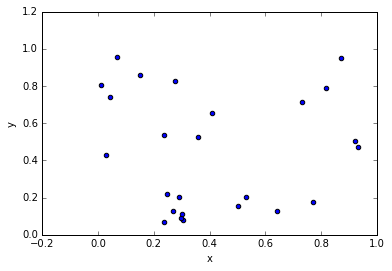

In [2]:
def grid_pts(n):
    """
    Make a list of x, y points spanning [0,1] covering the space evenly with n^2 points
    """
    xx,yy = np.meshgrid(np.arange(n),np.arange(n))
    stack_arr = np.stack([xx.flatten(),yy.flatten()],1).astype(np.float32)/(n-1)
    return pd.DataFrame(stack_arr,columns = ["x","y"])
def rand_pts(n):
    """
    Make a list of x, y points spanning [0,1] covering the space randomly with n^2 points
    """
    return pd.DataFrame(np.random.rand(n**2,2),columns = ["x","y"]) # ** is the power operator in python, avoid ^
def layer_maker(seed_pts, nlayers = 2, th_layer = 0, ch_amp = 0.1):
    """
    Makes random layer structures inside of lists of points
    :th_layer: is the angle the layer is rotated
    :ch_amp: is the amplitude of the fluctuations
    """
    ly_pts = seed_pts.copy()
    nx = np.cos(th_layer)*ly_pts['x']-np.sin(th_layer)*ly_pts['y']
    ny = np.sin(th_layer)*ly_pts['x']+np.cos(th_layer)*ly_pts['y']
    wave_val = np.sin(ny*2*np.pi*nlayers)>0
    ch_val = 1+ch_amp*wave_val
    ly_pts['Volume'] = ch_val*1000
    ly_pts['CV'] = wave_val
    return ly_pts
# make sure things work   
print(repr(grid_pts(3)))
# pandas has built in plotting methods
%matplotlib inline
rand_pts(5).plot.scatter('x','y')
layer_maker(grid_pts(3),th_layer = np.pi/4)

# Tasks

## Nearest Neighbors

Given our definition of nearest neighbors from the lecture, think about how you would implement it yourself (just conceptionally, for each point ...)

- ![Nearest Neighbor KNIME](08-files/NearestNeighbor.png)

Now try to understand what the above workflow does. Particularly important is the GroupBy Node. To fully understand this node, you need to look at both the main panel (Groups) and the Manual Aggregation panel. 

- What would changing the other values for 'Aggregation' get the result?

## Comparing Samples

Each of these samples was measured from a different treatment group, calculate general statistics about the same and try and determine what transformation was applied from the normal (sample-a) to get to this point. _Comparing histograms of nearest neighbor positions might be a good starting point._

You can look at the KNIME or workflows for help and then try to implement the nearest neighbor code yourself below



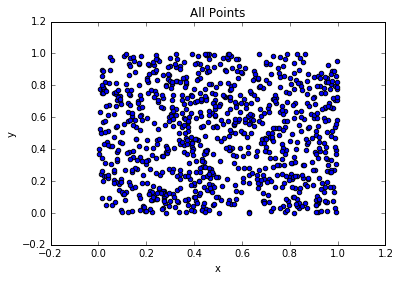

In [3]:
# setup the initial tools
starting_pts = rand_pts(30)
roi_fun = lambda idf: idf[(np.abs(idf['x']-0.2)<0.2) & (np.abs(idf['y']-0.2)<0.2)]
%matplotlib inline
starting_pts.plot.scatter('x','y', title = 'All Points') # all points

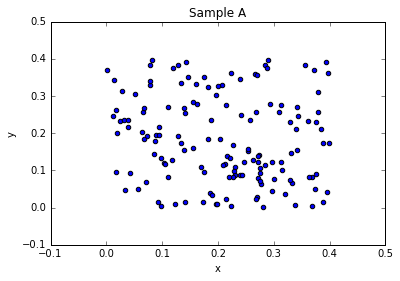

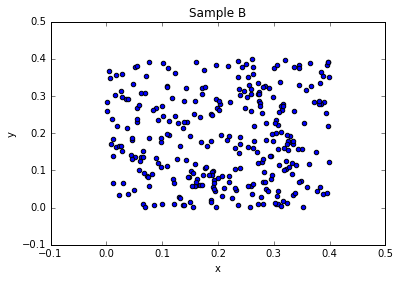

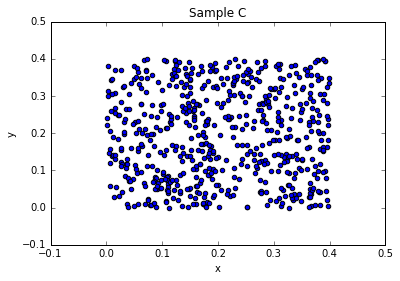

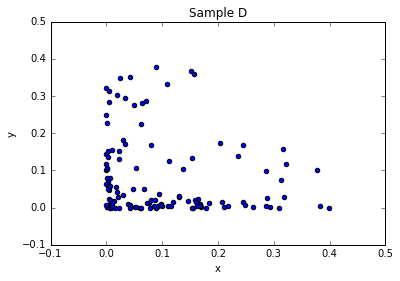

In [4]:
sample_a = roi_fun(starting_pts)
sample_a.plot.scatter('x','y', title = 'Sample A') 

sample_b = starting_pts.copy()
sample_b['x'] = sample_b['x']*0.7
sample_b['y'] = sample_b['y']*0.7
sample_b = roi_fun(sample_b)
sample_b.plot.scatter('x','y', title = 'Sample B') 

sample_c = starting_pts.copy()
sample_c['x'] = sample_c['x']*0.4
sample_c['y'] = sample_c['y']*0.6
sample_c = roi_fun(sample_c)
sample_c.plot.scatter('x','y', title = 'Sample C') 

sample_d = starting_pts.copy()
sample_d['x'] = np.power(sample_d['x']/0.5,3)
sample_d['y'] =  np.power(sample_d['y']/0.5,3)
sample_d = roi_fun(sample_d)
sample_d.plot.scatter('x','y', title = 'Sample D')

### Questions/Tasks
1. Modify the workflow to exclude all neighbors which are further than 0.05 away and replace the distance with 0.05
1. How would you find the nearest 5 neighbors instead of just the nearest? (Explanation or code)?


__Still in progress (direct from R)__



## Finding Layers in a Sample

These layers are distinguished by __Volume__

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
out.pts<-layer.maker(grid.pts(20))
ggplot(out.pts,aes(x,y,size=Volume))+
  geom_point()+theme_bw(20)+
  labs(title="simple_layer.csv")

write.pts(out.pts,"simple_layer.csv")
```

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
out.pts<-layer.maker(rand.pts(20),th.layer=pi/4)
ggplot(out.pts,aes(x,y,size=Volume))+
  geom_point()+theme_bw(20)+
  labs(title="tilted_layer.csv")
write.pts(out.pts,"tilted_layer.csv")
```


## Finding layers by spacing
- Files have prefix spacing_
- Since these layers are distiguished by the spacing between points, you should perform a K-Means clustering.
 - The number of groups and values used to calculate the K-means can be adjusted in the panel
 - Additional math blocks can be used to rescale other values (x and y for example for inclusion)

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
layer.maker<-function(seed.pts,n.pts=100,n.layers=2,th.layer=0,ch.amp=0.5,py.order=3) {
  nx<-with(seed.pts,cos(th.layer)*x-sin(th.layer)*y)
  ny<-with(seed.pts,sin(th.layer)*x+cos(th.layer)*y)
  
  class.fn<-function(iy) round(iy*n.layers)
  # create a fake y array that we will adjust the spacing for
  fy<-seq(min(ny),max(ny),length.out=2000)
  class.val<-class.fn(fy)
  step.size<-diff(fy)[1]
  fit.df<-data.frame(x=fy,CV=as.factor(class.fn(fy)),
                     new.y=cumsum((ch.amp*( class.fn(fy)%%2 )+(1-ch.amp/2))*step.size))
  
  fit.lm<-lm(new.y ~ x * CV,data=fit.df)
  
  real.df<-data.frame(x=ny,CV=as.factor(class.fn(ny)))
  real.df$ix<-nx
  real.df$comp.ny<-predict(fit.lm,newdata=real.df)

  creal.df<-real.df
  n.th<--1*th.layer
  out.df<-data.frame(x=with(creal.df,cos(n.th)*ix-sin(n.th)*comp.ny),
                     y=with(creal.df,sin(n.th)*ix+cos(n.th)*comp.ny))
  
  out.df
}
f.name<-"spacing_layer_grid.csv"
st.pnts<-layer.maker(grid.pts(40),th.layer=0*pi/10,n.layers=4)
ggplot(st.pnts,aes(x,y))+
  geom_point()+theme_bw(20)+
  labs(title=f.name,color="Layer")
write.pts(st.pnts,f.name)
```

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
f.name<-"spacing_layer_random.csv"
st.pnts<-rand.pts(40)
ly.cnt<-10
st.pnts<-cbind(st.pnts,CV=with(st.pnts,sin(y*2*pi*ly.cnt)>0))
st.pnts$x<-with(st.pnts,x*(0.75+CV*0.25))
ggplot(st.pnts,aes(x,y,color=CV))+
  geom_point()+theme_bw(20)+
  labs(title=f.name,color="Layer")

write.pts(st.pnts,f.name)
```


### More layers

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
f.name<-"spacing_layer_grid_angle.csv"
st.pnts<-layer.maker(grid.pts(40),th.layer=pi/3,n.layers=8)
ggplot(st.pnts,aes(x,y))+
  geom_point()+theme_bw(20)+
  labs(title=f.name,color="Layer")

write.pts(st.pnts,f.name)
```

```{r, fig.cap="All Cells",fig.height=7, results='asis'}
f.name<-"spacing_layer_random_angle.csv"
st.pnts<-layer.maker(rand.pts(60),th.layer=-pi/3,n.layers=4,ch.amp=0.4)
ggplot(st.pnts,aes(x,y))+
  geom_point()+theme_bw(20)+
  labs(title=f.name,color="Layer")

write.pts(st.pnts,f.name)
```

### Tasks
- From the K-means classification how can you count the layers automatically?
- What benefit might adding the position (x,y) into the results have?
- Would using N-nearest neighbors instead of nearest neighbor improve the results, if so for which kind of samples and why?


## Voronoi Tesselation (Pixel-based)

The goal of this task is to run a voronoi tesselation on the image to fill in the surrounding areas.

The results of the workflow should look like this
- ![Segmentation](08-files/VoronoiResults.png)

### Tasks/ Questions
1. How can you calculate territory from this voronoi tesselation?
1. Create a histogram of the local density?


## Classifying Cells

Using the analysis saved [here](https://github.com/kmader/Quantitative-Big-Imaging-Course/blob/master/Ex7/analyzeParticlesOutput.txt) located in the course directory along with the sample script. To classify cells into groups, right now we just use nearest neighbor distance and area, how does adding additional parameters change the result

### Challenge: 3D analysis

3D data analyzed with KNIME or in ImageJ using the _3D Object Analyzer_ function can also be analyzed using similar workflows. Can you modify the workflow so it works for 3D positions (x,y,z) as well (in KNIME or for ambitious students in R)?

## Alignment

- Which of the two samples are more aligned? Why? 


```{r, fig.cap="All Cells",fig.height=7, results='asis'}
f.name<-"align_a.csv"
opt.maker<-function(n.pts,rn.fun=function(pts) runif(pts,min=0,max=1),th.amp=0,...) {
  th.val<-runif(n.pts,min=-th.amp,max=th.amp)+pi*round(runif(n.pts))
  data.frame(x=rn.fun(n.pts),y=rn.fun(n.pts),
             xv=cos(th.val),yv=sin(th.val),
             th.amp=th.amp,n.pts=n.pts,
             label=paste("Avg:",round(mean(180/pi*th.val)*10)/10,"Sd:",round(sd(180/pi*th.val)*10)/10),...)
}
st.pnts<-opt.maker(100,th.amp=pi/10)
ggplot(st.pnts,
       aes(x,y,xend=x+0.2*xv,yend=y+0.2*yv))+
  geom_segment(aes(color="Orientation"),arrow=arrow(length = unit(0.15,"cm")))+
  geom_point(aes(color="COV"),alpha=0.7)+
  coord_equal()+
  labs(color="Type",title=f.name)+
  theme_bw(20)


write.pts(st.pnts[,c(1:4)],f.name)
```

- Can you find a method for calculating the alignment better appropriately for the second sample?


```{r, fig.cap="All Cells",fig.height=7, results='asis'}
f.name<-"align_b.csv"
st.pnts<-opt.maker(100,th.amp=0.1)
st.pnts$xv<-with(st.pnts,y/sqrt(x^2+y^2))
st.pnts$yv<-with(st.pnts,-x/sqrt(x^2+y^2))
ggplot(st.pnts,
       aes(x,y,xend=x+0.2*xv,yend=y+0.2*yv))+
  geom_segment(aes(color="Orientation"),arrow=arrow(length = unit(0.15,"cm")))+
  geom_point(aes(color="COV"),alpha=0.7)+
  coord_equal()+
  labs(color="Type",title=f.name)+
  theme_bw(20)

write.pts(st.pnts[,c(1:4)],f.name)
```